In [36]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import re
from sklearn.model_selection import GridSearchCV

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/cpan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
input_dir = '/Users/cpan/OneDrive - Guardant Health/page_classification_data/'
train_data = pd.read_csv(input_dir + 'train_docs_sm.csv')
valid_data = pd.read_csv(input_dir + 'valid_docs_sm.csv')
test_data = pd.read_csv(input_dir + 'test_docs_sm.csv')

In [76]:
train_data.iloc[6]

file_name                                  A0204311/image-007.txt
patient_id                                               A0204311
page_content    REDACTED Ha To 40204311 GUARDANT 369 DOB SEP 0...
label                                                           0
Name: 6, dtype: object

In [75]:
train_data.iloc[6]['page_content']

'REDACTED Ha To 40204311 GUARDANT 369 DOB SEP 01 1940 Test Number 4 Tumor Biology Page Guardant360 Tumor Response Map The Guardant360 Tumor Response Map illustrates the variant allele fraction cfDNA of observed somatic variants at each sample submission time point Amplifications are not plotted and only the first and last five test dates are plotted Please see the Physician Portal portal guardanthealth com for the Tumor Response Map with all test dates GUARDANTHEALTH Amore detailed Guardant360 Patient Report is available through our online portal TST PRT 001 V23 0 Pg 2of'

In [4]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, digits, and extra spaces
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Define your custom vocabulary to be added to stopwords
    custom_vocab = ["redacted", "redactedredacted", 'is', 'to', 'of', 'with', 'in', 'no']  # Add your domain-specific terms
    
    # Combine NLTK stopwords and custom vocabulary
    stop_words = set(stopwords.words('english') + custom_vocab)
    
    words = text.split()
    # filter out words that have length less than 2 
    filtered_words = [word for word in words if len(word) > 2 and word not in stop_words]
    text = ' '.join(filtered_words)
    
    return text
# Function to extract BERT embeddings for text data
def extract_bert_features(df):
    embeddings = []
    for text in df['page_content']:
        cleaned_text = clean_text(text)
        inputs = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        avg_pooling = torch.mean(last_hidden_states, dim=1)
        embeddings.append(avg_pooling.squeeze().numpy())
    return np.vstack(embeddings)

In [7]:
# Extract BERT features for train, validation, and test sets
train_features = extract_bert_features(train_data)
val_features = extract_bert_features(valid_data)
test_features = extract_bert_features(test_data)

In [77]:
test_data.shape

(326, 4)

In [8]:
X_train = train_features
y_train = train_data['label']
X_val = val_features
y_val = valid_data['label']

In [9]:
# use SMOTE to oversample minority classes 
smote = SMOTE(sampling_strategy=0.5, k_neighbors=5)  # Adjust k_neighbors as needed
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [35]:
joblib.dump(y_train_resampled, "resampled_y_train_ft.joblib")

['resampled_y_train_ft.joblib']

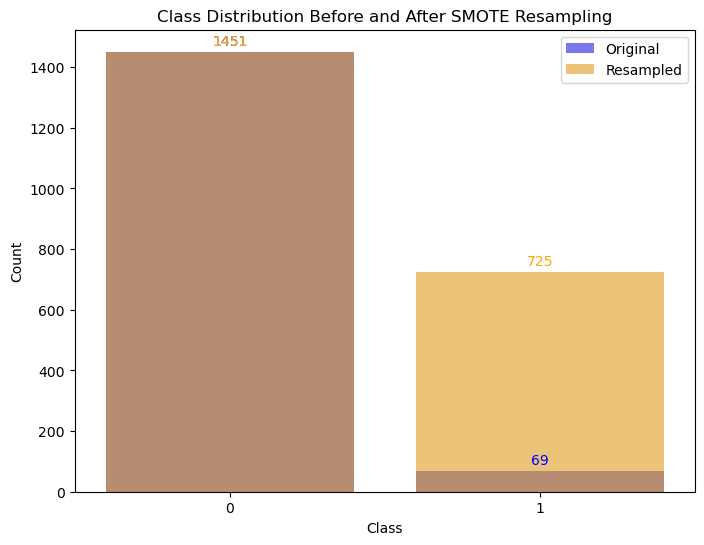

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class in the original and resampled datasets
original_class_counts = y_train.value_counts()
resampled_class_counts = pd.Series(y_train_resampled).value_counts()

# Create a bar plot to visualize class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=original_class_counts.index, y=original_class_counts.values, color='blue', alpha=0.6, label='Original')
sns.barplot(x=resampled_class_counts.index, y=resampled_class_counts.values, color='orange', alpha=0.6, label='Resampled')

# Annotate the bar plots with actual class counts
for index, value in enumerate(original_class_counts.values):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10, color='blue')

for index, value in enumerate(resampled_class_counts.values):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10, color='orange')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before and After SMOTE Resampling')
plt.legend()
plt.show()

In [14]:
X_test = test_features
y_test = test_data['label']

In [15]:
# standardize the embedding
scaler = StandardScaler()

# Fit the scaler on the training data and transform features
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Save BERT features to files
np.save(input_dir+'bert_train_features_ft_scaled.npy', X_train_scaled)
np.save(input_dir+'bert_val_features_ft_scaled.npy', X_val_scaled)
np.save(input_dir+'bert_test_features_ft_scaled.npy', X_test_scaled)

In [18]:
import joblib

In [20]:
pwd

'/Users/cpan/Desktop/project/notebooks'

In [22]:
best_xgb = joblib.load('/Users/cpan/Desktop/project/notebooks/best_xgb_model_hir.pkl')

In [46]:
# print(best_xgb.get_params())

In [47]:
# get the best parameters from previous trained xgb 
# Access the estimator from the loaded model
estimator = best_xgb.get_params()['estimator']

# Access the hyperparameters from the estimator
best_learning_rate = estimator.learning_rate
best_max_depth = estimator.max_depth
best_n_estimators = estimator.n_estimators
best_colsample_bytree = estimator.colsample_bytree

In [51]:
print(best_learning_rate)
print(best_max_depth)
print(best_n_estimators)
print(best_colsample_bytree)

None
None
100
None


In [52]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for fine-tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    # Add other hyperparameters you want to tune
}

# Initialize the previously best-fitted XGBoost model
best_xgb = XGBClassifier(
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators,
    colsample_bytree=best_colsample_bytree,
    # Set other hyperparameters here
)

# Create an instance of GridSearchCV with the best-fitted model and hyperparameter grid
grid_search = GridSearchCV(best_xgb, param_grid, scoring='f1_micro', cv=5)

# Fit the grid search on your validation data
grid_search.fit(X_train_scaled, y_train_resampled)

# Print the best hyperparameters and their corresponding performance score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Get the best estimator (model with the best hyperparameters) from the grid search
best_xgb_tuned = grid_search.best_estimator_

# Use the tuned model for predictions on the test set and evaluate its performance
y_pred_tuned = best_xgb_tuned.predict(X_test_scaled)
# Print classification report
print(classification_report(y_test, y_pred_tuned))


Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Best F1 Score: 0.9662470862470863
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       312
           1       1.00      0.21      0.35        14

    accuracy                           0.97       326
   macro avg       0.98      0.61      0.67       326
weighted avg       0.97      0.97      0.96       326



In [66]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       312
           1       1.00      0.21      0.35        14

    accuracy                           0.97       326
   macro avg       0.98      0.61      0.67       326
weighted avg       0.97      0.97      0.96       326



In [53]:
# Save the trained xgboost model
model_path = '/Users/cpan/Desktop/project/notebooks/'
model_filename = model_path+'tuned_xgb_model1.pkl'
joblib.dump(best_xgb, model_filename)

print("Model saved to", model_filename)

Model saved to /Users/cpan/Desktop/project/notebooks/tuned_xgb_model1.pkl


### Error Analysis

In [54]:
predictions_df = pd.DataFrame({"file_name": test_data["file_name"], 'patient_id': test_data['patient_id'], 'page_content':test_data['page_content'],"is_test": y_pred})

In [55]:
print(predictions_df.shape)
# predictions_df['is_test'].value_counts()print("F1-Score:", f1_score)

(326, 4)


In [64]:
# fine-tune xgboost error analysis
from sklearn.metrics import confusion_matrix

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tuned)
print("Confusion Matrix:")
print(conf_matrix)

# Find indices of misclassified examples
misclassified_indices = np.where(y_test != y_pred_tuned)[0]

# Print some of the misclassified examples for analysis
num_examples_to_print = 5
print("\nMisclassified Examples:")
for i in range(min(num_examples_to_print, len(misclassified_indices))):
    index = misclassified_indices[i]
    print(f"Example {i+1}:")
    print("True Label:", y_test.iloc[index])
    print("Predicted Label:", y_pred_tuned[index])
    print("Text:")
    print(test_data['page_content'].iloc[index])
    print("="*50)

# Analyze common words or phrases in misclassified examples
misclassified_text = test_data['page_content'].iloc[misclassified_indices]
miclassified_text_clean = [clean_text(text) for text in misclassified_text]
common_words = {}
for text in miclassified_text_clean:
    words = text.split()
    for word in words:
        if word not in common_words:
            common_words[word] = 1
        else:
            common_words[word] += 1

# Print most common words in misclassified examples
print("Common Words in Misclassified Examples:")
sorted_common_words = sorted(common_words.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_common_words[:10]:
    print(f"{word}: {count}")

Confusion Matrix:
[[312   0]
 [ 11   3]]

Misclassified Examples:
Example 1:
True Label: 1
Predicted Label: 0
Text:
CTCA Rightfax 1 22 2021 1 35 05 PM PAGE 9 040 Fax b5erver JACKSON REDACTED 6 15 2020 SEP20 534 REDACTED REDACTED 46263197 DOB AUG O1 1994 f Test Number 4 Definitions Somatic Afterations Not Detected ND or variant Characteristics may re dees not pr be present that are below the limit of detaction of this tivity The absence of delectable somatic alterations in circuiatir tumor in sampte 2 ONA interpretations Somatic altera types af yenum ions were NOT detected in th DNA isolated from this patient alterations chetented by GuardantséG This versiue of the Quardantsad tes is of gonomic alterations such as complex rearrangements or gene deletions nlood specirn not validated for toes the other types GUARBANT HE jad Guardtant360 Patient Report antine portat TST PRT 001 V2 Bortal quardanthealth com of to set up an aecount Gontaet Client Services 885 858 REDACTED REDACTED JONNA Page

In [65]:
print(len(misclassified_indices))

11


In [58]:
guardant_count = 0

# Analyze common words or phrases in misclassified examples
misclassified_text = test_data['page_content'].iloc[misclassified_indices]
misclassified_text_clean = [clean_text(text) for text in misclassified_text]

for text in misclassified_text_clean:
    if re.findall(r'\bguardant\b', text):  # Using \b to match whole word "guardant"
        guardant_count += 1

# Print the number of misclassified examples containing "guardant" or its part
print("Number of Misclassified Examples Containing 'guardant':", guardant_count)

Number of Misclassified Examples Containing 'guardant': 7


#### Filtering out the classification results that are guardant test only (not the final result)

In [67]:
import re

# List of competitor test names (not converted to lowercase)
company_test_list = ['FoundationOne Liquid', 'Plasma Focus', 'Liquid Hallmark', 'Genestrat, InVisionFirst-Lung',
                     'FoundationOne CDx', 'Caris Molecular Intelligence', 'OncoExtra', 'Altera', 'Invitae Cancer Screen', 'MyRisk']
not_lower_company_test_list = ['xF', 'xF+', 'Assure', 'xT']

# Create a copy of the predictions DataFrame to avoid modifying the original one
filtered_predictions_df = predictions_df.copy()

# Iterate through each row in the DataFrame
for index, row in filtered_predictions_df.iterrows():
    text_content = row['page_content']
    predicted_test = row['is_test']
    
    # Use re.findall to find partial matches for "guardant" (case-insensitive)
    guardant_matches = re.findall(r'guardant', text_content, re.IGNORECASE)
    
    # Check if the guardant_matches list is not empty and if the predicted test is 1
    if guardant_matches and predicted_test == 1:
        # Check if any competitor's test name is present in the text content (not converted to lowercase)
        if not any(spec_test in text_content for spec_test in not_lower_company_test_list):
            # Change the predicted label to 0
            filtered_predictions_df.at[index, 'is_test'] = 0
        if not any(test.lower() in text_content.lower() for test in company_test_list):
            filtered_predictions_df.at[index, 'is_test'] = 0

# Assuming y_true contains the true labels and filtered_predictions_df contains the modified predicted labels
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, filtered_predictions_df['is_test'], average='binary')

print("Precision after filtering:", precision)
print("Recall after filtering:", recall)
print("F1-Score after filtering:", f1_score)

Precision after filtering: 1.0
Recall after filtering: 0.42857142857142855
F1-Score after filtering: 0.6


In [69]:
print(classification_report(y_test, filtered_predictions_df['is_test']))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       312
           1       1.00      0.43      0.60        14

    accuracy                           0.98       326
   macro avg       0.99      0.71      0.79       326
weighted avg       0.98      0.98      0.97       326

